# package和数据导入

## 包导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import keras
layers = keras.layers
models = keras.models
optimizers = keras.optimizers

# pandas设置
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

Using Theano backend.


## 数据导入

In [2]:
eload = pd.read_excel("LoadData.xlsx", parse_dates=True, index_col='YMD').asfreq('D')
# eload.set_axis(range(0,24*60, 15),axis=1, inplace=True)
eload.set_axis(np.linspace(0, 24, 96, endpoint=False),axis=1, inplace=True)
eload.dropna(inplace=True)
eload.head()

,0.0,0.25,0.5,0.75,1.0,...,22.75,23.0,23.25,23.5,23.75
YMD,,,,,,,,,,,
2009-01-01,3210.842464,3104.507008,3037.705984,2960.176288,2889.226528,...,2734.114816,2610.683872,2485.757536,2382.696928,2276.210080
2009-01-02,2163.988288,2074.737568,1999.624960,1950.288448,1889.142112,...,3964.573792,3774.516256,3587.174176,3424.568608,3266.948608
2009-01-03,3109.127008,3015.901120,2938.305664,2869.375744,2815.772224,...,4127.941984,3955.490752,3774.541120,3602.281312,3444.148000
2009-01-04,3307.752544,3209.726368,3125.514016,3075.184864,3028.708768,...,4124.856256,3940.387648,3767.990560,3602.398720,3477.076768
2009-01-05,3295.415776,3278.379328,3232.313632,3160.731232,3124.226368,...,4710.734656,4471.342144,4295.259520,4106.356096,3933.511360


In [3]:
weather = pd.read_excel("LoadData.xlsx", sheet_name='Area1_Weather',
                        parse_dates=True, index_col='YMD').asfreq('D')
weather.dropna(inplace=True)
weather.head()

,最高温度℃,最低温度℃,平均温度℃,相对湿度(平均),降雨量（mm）
YMD,,,,,
2012-01-01,19.5,12.1,15.8,63.0,0.0
2012-01-02,20.0,13.0,16.0,59.0,0.0
2012-01-03,18.7,14.2,15.8,72.0,0.0
2012-01-04,14.9,9.3,10.9,62.0,0.0
2012-01-05,9.2,5.1,6.9,78.0,2.9


## 可视化：负荷长期趋势

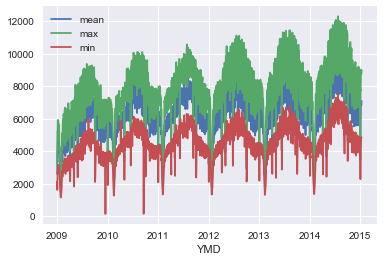

In [4]:
eload.mean(axis=1).plot(label='mean')
eload.max(axis=1).plot(label='max')
eload.min(axis=1).plot(label='min')
plt.legend()
plt.show()

## 爬虫：节假日数据获取

In [ ]:
import requests as req
import json

is_weekend = {6:1,0:0,1:0,2:0,3:0,4:0,5:1}
weekend = [is_weekend[day] for day in weather.index.dayofweek]

is_holiday = pd.Series(data=weekend,index=weather.index,name='休息日')
for year in range(2012,2016):
    for month in range(1,13):
        api = "https://sp0.baidu.com/8aQDcjqpAAV3otqbppnN2DJv/api.php?query=%(y)s年%(m)s月"%\
        {'y':year,'m':month}
        res = req.get(api)
        holiday = json.loads(res.text[46:-2])['data'][0]['holiday']
        if isinstance(holiday,dict):
            holiday = [holiday,]
        for i in range(len(holiday)):
            holidaylist = holiday[i]['list']
            for obj in holidaylist:
                is_holiday[obj['date']] = 2-int(obj['status'])

In [5]:
xxr = pd.read_csv('xxr.csv',index_col='YMD',parse_dates=True).asfreq('D')
xxr

,休息日
YMD,
2012-01-01,1.0
2012-01-02,1.0
2012-01-03,1.0
2012-01-04,0.0
2012-01-05,0.0
...,...
2015-01-13,0.0
2015-01-14,0.0
2015-01-15,0.0


## 丢失数据处理

In [6]:
# 取交集
regweather = weather.dropna()
regload = eload.reindex(regweather.index).dropna()
regweather = regweather.reindex(regload.index).dropna()

# 数据预处理

## min-max 标准化

### 负荷数据标准化

In [7]:
load_min = regload.T.min()
load_max = regload.T.max()
load = ((regload.T - load_min) / (load_max - load_min)).T

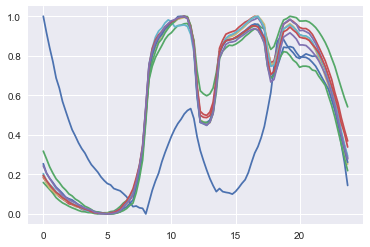

In [8]:
load[:10].T.plot();plt.legend('');plt.show()

In [9]:
# Data split
train_tar = load[:900]
val_tar = load[900:1097]
test_tar = load[1097:]

### 天气数据标准化

In [10]:
train_data = regweather[:900]
val_data = regweather[900:1097]
test_data = regweather[1097:]

In [11]:
weather_min = train_data.min()
weather_max = train_data.max()

train_data,val_data,test_data = [((data - weather_min) / (weather_max - weather_min)).join(xxr) \
                                 for data in (train_data,val_data,test_data)]

In [12]:
test_data

,最高温度℃,最低温度℃,平均温度℃,相对湿度(平均),降雨量（mm）,休息日
YMD,,,,,,
2015-01-04,0.340862,0.309237,0.409091,0.628205,0.0,1.0
2015-01-05,0.363450,0.518072,0.537879,0.717949,0.0,0.0
2015-01-06,0.392197,0.598394,0.598485,0.743590,0.0,0.0
2015-01-07,0.326489,0.429719,0.409091,0.679487,0.0,0.0
2015-01-08,0.240246,0.253012,0.318182,0.423077,0.0,0.0
2015-01-09,0.229979,0.289157,0.321970,0.410256,0.0,0.0
2015-01-10,0.281314,0.325301,0.375000,0.423077,0.0,1.0


## z-score 标准化

### 负荷数据标准化

In [28]:
load_mean = train_data.mean(axis=1)
load_std = train_data.std(axis=1)
eload = train_data.sub(load_mean, axis=0).div(load_std, axis=0)
eload

,0.0,0.25,0.5,0.75,1.0,...,22.75,23.0,23.25,23.5,23.75
YMD,,,,,,,,,,,
2012-01-01,2.159909,1.858176,1.580860,1.329830,1.032728,...,0.492892,0.177314,-0.173168,-0.508084,-0.930209
2012-01-02,-1.103612,-1.149546,-1.194899,-1.243119,-1.300987,...,0.403066,0.261467,0.126132,-0.005680,-0.121718
2012-01-03,-1.004767,-1.070471,-1.136297,-1.179536,-1.216172,...,0.099107,-0.040613,-0.226634,-0.383972,-0.531649
2012-01-04,-0.961316,-1.041153,-1.101148,-1.147513,-1.187994,...,-0.039412,-0.212192,-0.412647,-0.571289,-0.734573
2012-01-05,-0.949826,-1.043470,-1.111331,-1.144656,-1.188993,...,-0.072192,-0.275443,-0.471838,-0.632884,-0.794785
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06,-1.014524,-1.071566,-1.122997,-1.156754,-1.195276,...,-0.139570,-0.305871,-0.481586,-0.643717,-0.803652
2015-01-07,-0.990555,-1.032539,-1.101457,-1.118695,-1.160063,...,-0.213174,-0.377656,-0.557447,-0.730454,-0.869975
2015-01-08,-0.962950,-1.026651,-1.086396,-1.114272,-1.155007,...,-0.122477,-0.306539,-0.505698,-0.663899,-0.846856


### 天气数据标准化

In [ ]:
def normalize(data, base, std):
    return data.sub(base, axis=1).div(std, axis=1)

data_base, data_std = train_data.mean(axis=0), train_data.std(axis=0)
train_data, val_data, test_data = \
(normalize(data, data_base, data_std) for data in [train_data, val_data, test_data])

In [ ]:
train_data = train_data.join(xxr)
val_data = val_data.join(xxr)
test_data = test_data.join(xxr)

In [ ]:
tar_base = train_tar.mean(axis=0)
tar_std = train_tar.std(axis=0)

train_tar, val_tar, test_tar = (normalize(tar, tar_base, tar_std) for tar in [train_tar, val_tar, test_tar])

# 构建模型

In [13]:
regularizers = keras.regularizers
model = models.Sequential()
model.add(layers.Dense(8,input_dim = len(train_data.columns), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(96))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [14]:
# 训练批次设置
EPOCHS = 200

his = model.fit(train_data, train_tar, epochs=EPOCHS, batch_size=7,
                validation_data=(val_data, val_tar), verbose=False)

In [15]:
train_loss = his.history['loss']
val_loss = his.history['val_loss']
train_mae = his.history['mean_absolute_error']
val_mae = his.history['val_mean_absolute_error']

In [16]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

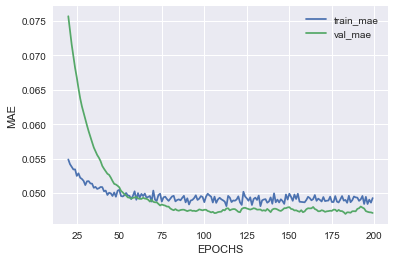

In [24]:
t0=20
plt.plot(his.epoch[t0:], train_mae[t0:], label = 'train_mae')
plt.plot(his.epoch[t0:], smooth_curve(val_mae)[t0:], label = 'val_mae', )
plt.legend();plt.xlabel('EPOCHS');plt.ylabel('MAE')
plt.show()

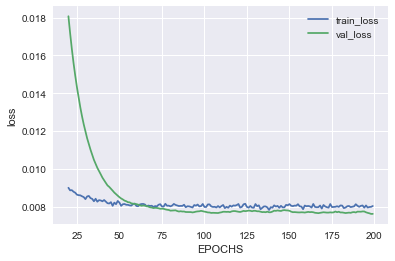

In [23]:
plt.plot(his.epoch[t0:], train_loss[t0:], label = 'train_loss')
plt.plot(his.epoch[t0:], smooth_curve(val_loss)[t0:], label = 'val_loss', )
plt.legend();plt.xlabel('EPOCHS');plt.ylabel('loss')
plt.show()

In [18]:
model.evaluate(test_data,test_tar)

7/7 [==============================] - 0s 0us/step


[0.0011899134842678905, 0.02766101062297821]

## 模型优化

In [ ]:
# 待补充

# 预测

In [19]:
# for min-max
a = test_tar.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()
b = pd.DataFrame(model.predict(test_data), index=test_tar.index,columns=test_tar.columns)
b = b.mul(load_max - load_min, axis=0).dropna().add(load_min,axis=0).dropna()

In [ ]:
# # for z-score
# a = test_tar.mul(std, axis=0).add(mean,axis=0).dropna()
# b = pd.DataFrame(model.predict(test_data),index=test_tar.index,columns=test_tar.columns)
# b = b.mul(std, axis=0).add(mean,axis=0).dropna()

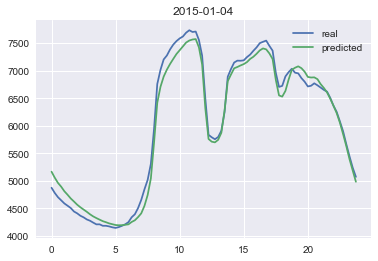

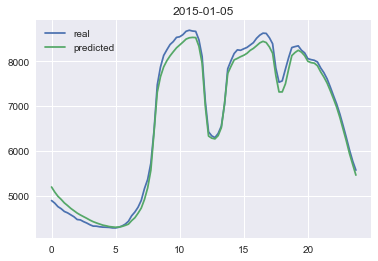

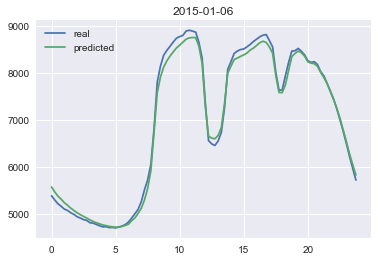

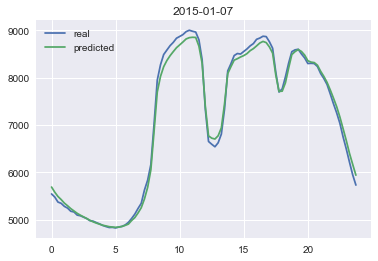

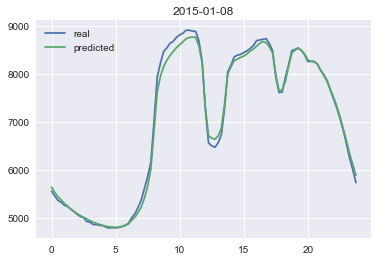

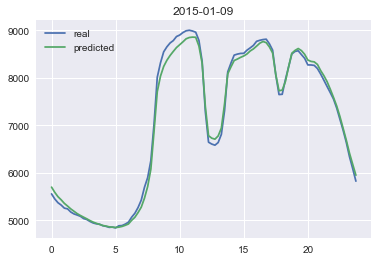

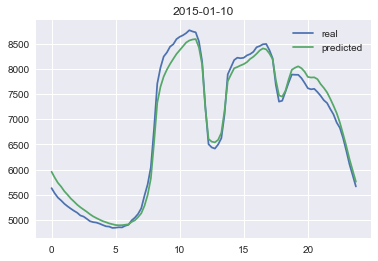

In [20]:
# 预测曲线和实际曲线对比
for i in range(len(test_data.index)):
    plt.plot(a.iloc[i])
    plt.plot(test_tar.columns,b.iloc[i])
    plt.legend(['real','predicted'])
    plt.title(str(test_tar.index[i])[:10])
    plt.show()

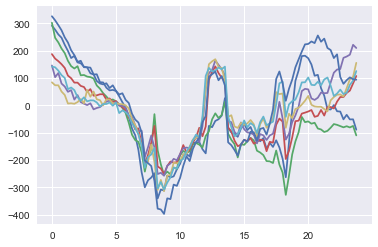

In [21]:
# 误差曲线
(b-a).T.plot();plt.legend('');plt.show()